# Density Matrix Renormalization Group (DMR)

In this tutorial we will perform Density Matrix Renormalization Group (DMRG) computations on different model Hamiltonians in order to extract both the ground-state (GS) and the first excited state (XS).

## 1-Site DMRG of the XY spin-1/2 chain

As a first step we will consider the 1-site DMRG algorithm.

Consider the Hamiltonian of a XY spin-1/2 chain, i.e. for a chain of spins where only the x and y components of neighboring spins are coupled:

\begin{equation}
\begin{split}
\hat{H} &= -J\sum_{l=1}^{N-1}(\hat{S}_{l}^{x}\hat{S}_{l+1}^{x}+\hat{S}_{l}^{y}\hat{S}_{l+1}^{y})=\\
&=-\frac{J}{2}\sum_{l=1}^{N-1}(\hat{S}_{l}^{+}\hat{S}_{l+1}^{-}+\hat{S}_{l}^{-}\hat{S}_{l+1}^{+})
\end{split}
\end{equation}

This Hamiltonian is exactly solvable by using the Jordan-Wigner transformation, which maps it into free spinless fermions in 1D. Thus, for even N, the GS energy has the analytic expression:

\begin{equation}
E_0 = \frac{1}{2}-\frac{1}{2sin(\frac{\pi}{2(N+1)})}
\end{equation}

Denoting $|\Psi_0>$ the ground-state wave-function, the spin correlation function has also an analytic expression:

\begin{equation}
<\Psi_0|\hat{S}_{l}^{+}\hat{S}_{l+1}^{-}|\Psi_0>=<\Psi_0|\hat{S}_{l}^{-}\hat{S}_{l+1}^{+}|\Psi_0>=-\frac{1}{2(N+1)}\Bigl[\frac{(-1)^l}{sin(\frac{(2l+1)\pi}{2(N+1)})}-\frac{1}{sin(\frac{\pi}{2(N+1)})}\Bigr]
\end{equation}

In [1]:
# First of all load all the modules
include("../include_modules.jl");
# Add PyPlot
using PyPlot

In [2]:
# System parameters
J = -1; # Coupling
N = 40; # Number of sites in the chain

# DMRG parameters
Nkeep  = 30; # Bond dimension
Nsweep =  4; # Number of left<->right sweeps

The XY hamiltonian is implemented in the form of matrix product operator (MPO):

\begin{equation}
H_{loc}=
\begin{bmatrix}
    \mathbb{1} & 0 & 0 & 0 \\
    S^+ & 0 & 0 & 0 \\
    S^- & 0 & 0 & 0 \\
    0 & -\frac{J}{2}S^- & -\frac{J}{2}S^+ & \mathbb{1} \\
\end{bmatrix}
\end{equation}

In [3]:
# Local base
S,Id = getLocalSpace("Spin",0.5);

# Generate the MPO Hamiltonian at a single site
Hloc = MPO_XY(J);

# Generate the MPO for the whole chain
# leg order: left-bottom-right-top
Hs = Vector{Union{Nothing, Array{Float64,3}, Array{Float64,4}}}(nothing, N);
for i in 1:N
       Hs[i] = Hloc[:,:,:,:];
end
Hs[1] = reshape(Hs[1][end,:,:,:],(1,2,4,2));   # last components of the left leg
Hs[end] = reshape(Hs[end][:,:,1,:],(4,2,1,2)); # first components of the right leg

In [4]:
# Run the 1-site DMRG
M0,E0,Eiter0 = DMRG_1site(Hs,Nkeep,Nsweep);

Single-site DMRG: search for the ground state.
# of sites = 40, Nkeep = 30, # of sweeps = 8.
20/11/2020 13:37:56 (GMT) | Initialize with iterative diagonalization. Energy = [-12.311612985887528]
20/11/2020 13:38:3 (GMT) | Sweep # 1/8 (right -> left) : Energy = -12.55385918852945
20/11/2020 13:38:7 (GMT) | Sweep # 2/8 (left -> right) : Energy = -12.55389676569403
20/11/2020 13:38:11 (GMT) | Sweep # 3/8 (right -> left) : Energy = -12.55389716957646
20/11/2020 13:38:16 (GMT) | Sweep # 4/8 (left -> right) : Energy = -12.5538972556197
20/11/2020 13:38:20 (GMT) | Sweep # 5/8 (right -> left) : Energy = -12.553897328196253
20/11/2020 13:38:24 (GMT) | Sweep # 6/8 (left -> right) : Energy = -12.553897397158128
20/11/2020 13:38:27 (GMT) | Sweep # 7/8 (right -> left) : Energy = -12.553897468956258
20/11/2020 13:38:31 (GMT) | Sweep # 8/8 (left -> right) : Energy = -12.553897530292286
Elapsed time: 42.75191807746887 s | Ground-state energy = -12.553897530292286


In [5]:
# Compare with the exact result
E0_exact = 0.5 - (1/2/sin(pi/2/(N+1))); # Exact result
println("Exact GS Energy = $(E0_exact) | DMRG Energy = $(E0) | error = $(abs(E0-E0_exact))")

Exact GS Energy = -12.553898555811893 | DMRG Energy = -12.553897530292286 | error = 1.0255196070119155e-6


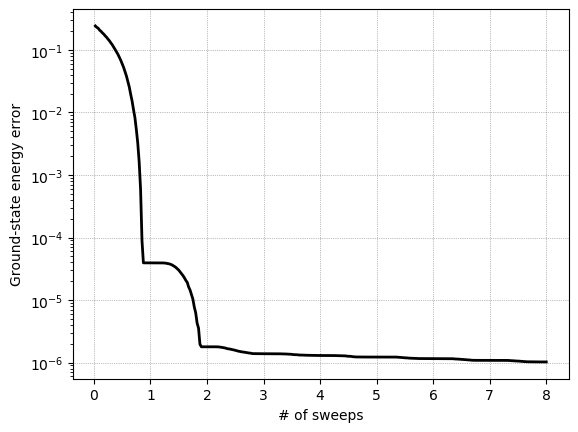

In [6]:
# Plot the error
x = (1:1:length(Eiter0))/N
Error = Eiter0.-E0_exact;
Error = reshape(Error,(length(Error)))

ylabel("Ground-state energy error");
xlabel("# of sweeps");
grid(linewidth=0.5,color="black",linestyle="dotted",alpha=0.5);
semilogy(x,Error,linewidth=2.0,color="black");

The error we make is $O(10^{-6})$, which can be further decreased by increasing Nkeep: indeed, the accuracy of such method is set by the finite bond dimension since the system is gapless. Consider a bipartition of the chain, into left and right halves. The entanglement between two parts in the ground state increases with the system size N logarithmically, for gapless systems. Thus, to achieve the same accuracy, we should use larger bond dimension that increases as the power law of N.
On the other hand, for the gapped systems, high accuracy can be achieved with small bond dimensions. For example, the AKLT model needs only the bond dimension 2.

We now compute the spin-spin correlation function $<\hat{S}_{l}^{+}\hat{S}_{l+1}^{-}>$, keeping in mind that our ground-state M is in LC form.

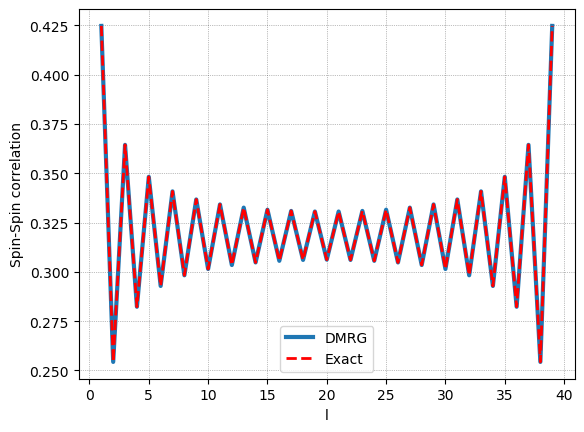

In [7]:
SS = zeros(N-1);

for itN in 2:N
    T = updateLeft([],[],M0[itN-1],reshape(S[:,1,:],(2,1,2)),3,M0[itN-1]);
    T = updateLeft(T,3,M0[itN],reshape(S[:,2,:],(2,1,2)),3,M0[itN]);
    for itN2 in (itN+1):N
        T = updateLeft(T,2,M0[itN2],[],[],M0[itN2]);
    end
    SS[itN-1] = T[1];
end
SS = SS.*(2); # the factor 2 is due to the presence of 1/sqrt(2) in both S[:,1,:] and S[:,2,:]

# Exact result
SS_exact = zeros(N-1);
for itN in 1:(N-1)
    SS_exact[itN] = (((-1)^(itN))/sin((2*itN+1)*pi/2/(N+1)) - 1/sin(pi/2/(N+1)))/(-2*(N+1));
end

x = (1:(N-1));
ylabel("Spin-Spin correlation");
xlabel("l")
grid(linewidth=0.5,color="black",linestyle="dotted",alpha=0.5);
plot(x,SS,linewidth=3.0,label="DMRG");
plot(x,SS_exact,"--",linewidth=2.0,label="Exact",color="red");
legend(loc="upper rigth");

We now move to study the first excited state $|\Psi_1>$ of the XY spin-1/2 chain, i.e. we will search for the MPS within the subspace orthogonal to the GS $|\Psi_0>$ while minimizing the energy expectation value.

The energy of $|\Psi_1>$ is analytically given by:

\begin{equation}
E_1 = E_0 + sin(\frac{\pi}{2(N+1)})
\end{equation}

In [8]:
# First of all we obtain again the GS, with more sweeps to ensure convergence;
# System parameters
J = -1; # Coupling
N = 40; # Number of sites in the chain

# DMRG parameters
Nkeep  = 30; # Bond dimension
Nsweep =  6; # Number of left<->right sweeps

# Local base
S,Id = getLocalSpace("Spin",0.5);

# Generate the MPO Hamiltonian at a single site
Hloc = MPO_XY(J);

# Generate the MPO for the whole chain
# leg order: left-bottom-right-top
Hs = Vector{Union{Nothing, Array{Float64,3}, Array{Float64,4}}}(nothing, N);
for i in 1:N
       Hs[i] = Hloc[:,:,:,:];
end
Hs[1] = reshape(Hs[1][end,:,:,:],(1,2,4,2));   # last components of the left leg
Hs[end] = reshape(Hs[end][:,:,1,:],(4,2,1,2)); # first components of the right leg

# Run the 1-site DMRG for the GS
M_GS,E_GS,Eiter_GS = DMRG_1site(Hs,Nkeep,Nsweep);

# Use the GS solution as input for the 1st excited state
M1,E1,Eiter1 = DMRG_1site(Hs,Nkeep,Nsweep,"Morth",M_GS);

# Compute the exact energy for comparison
E0_exact = 0.5 - (1/2/sin(pi/2/(N+1))); # ground-state energy, exact value
E1_exact = E0_exact + sin(pi/2/(N+1)); # first excitation energy, exact value
println("1st Excitation Energy = $(E1_exact) | DMRG Energy = $(E1) | error = $(abs(E1-E1_exact))")

Single-site DMRG: search for the ground state.
# of sites = 40, Nkeep = 30, # of sweeps = 12.
20/11/2020 13:39:7 (GMT) | Initialize with iterative diagonalization. Energy = [-12.311612985887528]
20/11/2020 13:39:11 (GMT) | Sweep # 1/12 (right -> left) : Energy = -12.55385918852945
20/11/2020 13:39:14 (GMT) | Sweep # 2/12 (left -> right) : Energy = -12.55389676569403
20/11/2020 13:39:19 (GMT) | Sweep # 3/12 (right -> left) : Energy = -12.55389716957646
20/11/2020 13:39:24 (GMT) | Sweep # 4/12 (left -> right) : Energy = -12.5538972556197
20/11/2020 13:39:28 (GMT) | Sweep # 5/12 (right -> left) : Energy = -12.553897328196253
20/11/2020 13:39:32 (GMT) | Sweep # 6/12 (left -> right) : Energy = -12.553897397158128
20/11/2020 13:39:36 (GMT) | Sweep # 7/12 (right -> left) : Energy = -12.553897468956258
20/11/2020 13:39:39 (GMT) | Sweep # 8/12 (left -> right) : Energy = -12.553897530292286
20/11/2020 13:39:44 (GMT) | Sweep # 9/12 (right -> left) : Energy = -12.553897572999528
20/11/2020 13:39:4

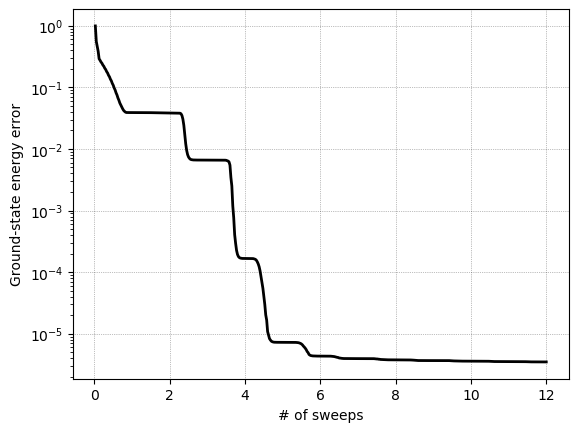

In [9]:
# Plot the error
x = (1:1:length(Eiter1))/N
Error1 = Eiter1.-E1_exact;
Error1 = reshape(Error1,(length(Error1)))

ylabel("Ground-state energy error");
xlabel("# of sweeps");
grid(linewidth=0.5,color="black",linestyle="dotted",alpha=0.5);
semilogy(x,Error1,linewidth=2.0,color="black");

Similarly to the ground state search, the accuracy of the first excited state energy also improves by increasing the bond dimension Nkeep.

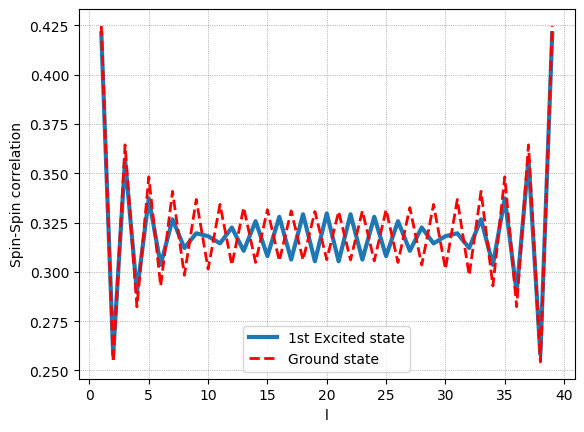

In [10]:
SS = zeros(N-1);

for itN in 2:N
    T = updateLeft([],[],M1[itN-1],reshape(S[:,1,:],(2,1,2)),3,M1[itN-1]);
    T = updateLeft(T,3,M1[itN],reshape(S[:,2,:],(2,1,2)),3,M1[itN]);
    for itN2 in (itN+1):N
        T = updateLeft(T,2,M1[itN2],[],[],M1[itN2]);
    end
    SS[itN-1] = T[1];
end
SS = SS.*(2); # the factor 2 is due to the presence of 1/sqrt(2) in both S[:,1,:] and S[:,2,:]

# Exact result
SS_exact = zeros(N-1);
for itN in 1:(N-1)
    SS_exact[itN] = (((-1)^(itN))/sin((2*itN+1)*pi/2/(N+1)) - 1/sin(pi/2/(N+1)))/(-2*(N+1));
end

x = (1:(N-1));
ylabel("Spin-Spin correlation");
xlabel("l")
grid(linewidth=0.5,color="black",linestyle="dotted",alpha=0.5);
plot(x,SS,linewidth=3.0,label="1st Excited state");
plot(x,SS_exact,"--",linewidth=2.0,label="Ground state",color="red");
legend(loc="upper rigth");

## 1-Site DMRG of the Majumdar-Ghosh model

The Majumdar–Ghosh model is a one-dimensional quantum Heisenberg spin-1/2 model in which the nearest-neighbour antiferromagnetic exchange interaction is twice as strong as the next-nearest-neighbour interaction. It is a special case of the more general $J_1-J_2$ model with $J_1 = 2*J_2$:

\begin{equation}
\hat{H} = J_1\sum_{l=1}^{N-1}(\hat{\bf{S}}_{l}\cdot\hat{\bf{S}}_{l+1}) + J_2\sum_{l=1}^{N-2}(\hat{\bf{S}}_{l}\cdot\hat{\bf{S}}_{l+2})
\end{equation}

Also in this case it is possible to find the exact ground-state energy in an analytical way:

\begin{equation}
E_0 = -\frac{3N}{8}
\end{equation}

where $N$ is the number of sites in the chain.

Its MPO form is given by:

\begin{equation}
H_{loc}=
\begin{bmatrix}
    \mathbb{1} & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    S^+ & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    S^- & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    S^z & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    0 & \mathbb{1} & 0 & 0 & 0 & 0 & 0 & 0 \\
    0 & 0 & \mathbb{1} & 0 & 0 & 0 & 0 & 0 \\
    0 & 0 & 0 & \mathbb{1} & 0 & 0 & 0 & 0 \\
    0 & J_1S^- & J_1S^+ & J_1S^z & J_2S^- & J_2S^+ & J_1S^z & \mathbb{1} \\
\end{bmatrix}
\end{equation}

In [11]:
# First of all we obtain the GS
# System parameters
J1 = 1;   # nearest-neighbour coupling strength
J2 = 0.5; # next-nearest-neighbour coupling strength
N = 40; # Number of sites in the chain

# DMRG parameters
Nkeep  = 2; # Bond dimension
Nsweep = 5; # Number of left<->right sweeps

# Local base
S,Id = getLocalSpace("Spin",0.5);

# Generate the MPO Hamiltonian at a single site
Hloc = MPO_MG(J1,J2);

# Generate the MPO for the whole chain
# leg order: left-bottom-right-top
Hs = Vector{Union{Nothing, Array{Float64,3}, Array{Float64,4}}}(nothing, N);
for i in 1:N
       Hs[i] = Hloc[:,:,:,:];
end
Hs[1] = reshape(Hs[1][end,:,:,:],(1,2,size(Hloc,3),2));   # last components of the left leg
Hs[end] = reshape(Hs[end][:,:,1,:],(size(Hloc,1),2,1,2)); # first components of the right leg

# Run the 1-site DMRG for the GS
M_GS,E_GS,Eiter_GS = DMRG_1site(Hs,Nkeep,Nsweep);

# Use the GS solution as input for the 1st excited state
M1,E1,Eiter1 = DMRG_1site(Hs,Nkeep,Nsweep,"Morth",M_GS);

# Compute the exact energy for comparison
E0_exact = -3*N/8; # ground-state energy, exact value
println("Exact GS Energy = $(E0_exact) | DMRG Energy = $(E_GS) | error = $(abs(E_GS-E0_exact))")

Single-site DMRG: search for the ground state.
# of sites = 40, Nkeep = 2, # of sweeps = 10.
20/11/2020 13:41:17 (GMT) | Initialize with iterative diagonalization. Energy = [-13.39059230407731]
20/11/2020 13:41:17 (GMT) | Sweep # 1/10 (right -> left) : Energy = -14.980101382412109
20/11/2020 13:41:17 (GMT) | Sweep # 2/10 (left -> right) : Energy = -14.999912079704533
20/11/2020 13:41:17 (GMT) | Sweep # 3/10 (right -> left) : Energy = -14.99999972800419
20/11/2020 13:41:17 (GMT) | Sweep # 4/10 (left -> right) : Energy = -14.999999999176033
20/11/2020 13:41:17 (GMT) | Sweep # 5/10 (right -> left) : Energy = -14.999999999997497
20/11/2020 13:41:17 (GMT) | Sweep # 6/10 (left -> right) : Energy = -15.000000000000062
20/11/2020 13:41:17 (GMT) | Sweep # 7/10 (right -> left) : Energy = -14.999999999999961
20/11/2020 13:41:17 (GMT) | Sweep # 8/10 (left -> right) : Energy = -14.999999999999993
20/11/2020 13:41:17 (GMT) | Sweep # 9/10 (right -> left) : Energy = -14.999999999999957
20/11/2020 13:4

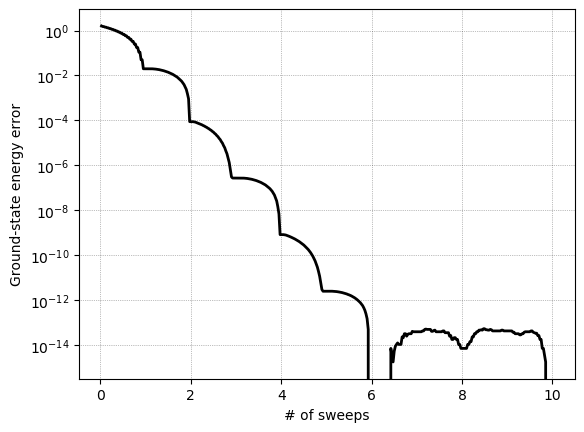

In [12]:
# Plot the error
x = (1:1:length(Eiter_GS))/N
Error = Eiter_GS.-E0_exact;
Error = reshape(Error,(length(Error)))

ylabel("Ground-state energy error");
xlabel("# of sweeps");
grid(linewidth=0.5,color="black",linestyle="dotted",alpha=0.5);
semilogy(x,Error,linewidth=2.0,color="black");

The error is of the order of double precision. If one initializes the MPS with random numbers, it is hard to reach this accuracy with bond dimension 2. As the single-site DMRG searches the ground state variationally, it is possible that the search gets stuck to local minima. Indeed, this issue of getting stuck to local minima is the weakness of the single-site DMRG method. The two-site update method of the DMRG can reach the global minimum more reliably.

Why is the bond dimension 2 is enough to reproduce the exact result of the ground-state energy? It is because the Majumdar-Ghosh model is gapped, and its ground state is described by the direct product of dimers for nearest neighbours, which can be seen from the spin-spin correlation function.

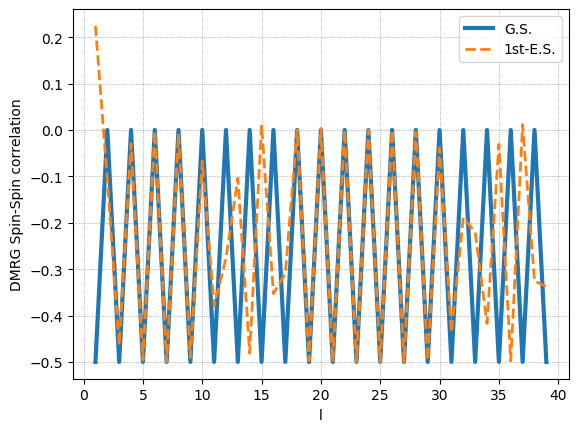

In [13]:
# G.S. SS-correlation
SS = zeros(N-1);

for itN in 2:N
    T = updateLeft([],[],M_GS[itN-1],reshape(S[:,1,:],(2,1,2)),3,M_GS[itN-1]);
    T = updateLeft(T,3,M_GS[itN],reshape(S[:,2,:],(2,1,2)),3,M_GS[itN]);
    for itN2 in (itN+1):N
        T = updateLeft(T,2,M_GS[itN2],[],[],M_GS[itN2]);
    end
    SS[itN-1] = T[1];
end
SS = SS.*(2); # the factor 2 is due to the presence of 1/sqrt(2) in both S[:,1,:] and S[:,2,:]

# 1st-E.S. SS-correlation
SSE = zeros(N-1);

for itN in 2:N
    T = updateLeft([],[],M1[itN-1],reshape(S[:,1,:],(2,1,2)),3,M1[itN-1]);
    T = updateLeft(T,3,M1[itN],reshape(S[:,2,:],(2,1,2)),3,M1[itN]);
    for itN2 in (itN+1):N
        T = updateLeft(T,2,M1[itN2],[],[],M1[itN2]);
    end
    SSE[itN-1] = T[1];
end
SSE = SSE.*(2); # the factor 2 is due to the presence of 1/sqrt(2) in both S[:,1,:] and S[:,2,:]

x = (1:(N-1));
ylabel("DMRG Spin-Spin correlation");
xlabel("l")
grid(linewidth=0.5,color="black",linestyle="dotted",alpha=0.5);
plot(x,SS,linewidth=3.0,label="G.S.");
plot(x,SSE,"--",linewidth=2.0,label="1st-E.S.");
legend(loc="upper rigth");

The spin-spin correlation function oscillates between -0.5 and 0, with periodicity 2.

## 2-site DMRG for Majumdar-Ghosh model

We now perform the 2-site DMRG calculation on the Majumdar-Ghosh model.
This time we increase Nkeep in order to show the strength of the 2-site algorithm.

Let's start with the ground-state:

In [14]:
# First of all we obtain the GS
# System parameters
J1 = 1;   # nearest-neighbour coupling strength
J2 = 0.5; # next-nearest-neighbour coupling strength
N = 40; # Number of sites in the chain

# DMRG parameters
Nkeep  = 30; # Bond dimension
Nsweep = 5; # Number of left<->right sweeps

# Local base
S,Id = getLocalSpace("Spin",0.5);

# Generate the MPO Hamiltonian at a single site
Hloc = MPO_MG(J1,J2);

# Generate the MPO for the whole chain
# leg order: left-bottom-right-top
Hs = Vector{Union{Nothing, Array{Float64,3}, Array{Float64,4}}}(nothing, N);
for i in 1:N
       Hs[i] = Hloc[:,:,:,:];
end
Hs[1] = reshape(Hs[1][end,:,:,:],(1,2,size(Hloc,3),2));   # last components of the left leg
Hs[end] = reshape(Hs[end][:,:,1,:],(size(Hloc,1),2,1,2)); # first components of the right leg

# Run the 1-site DMRG for the GS
M_GS,E_GS,Eiter_GS = DMRG_2site(Hs,Nkeep,Nsweep);

# Compute the exact energy for comparison
E0_exact = -3*N/8; # ground-state energy, exact value
println("Exact GS Energy = $(E0_exact) | DMRG Energy = $(E_GS) | error = $(abs(E_GS-E0_exact))")

Two-site DMRG: search for the ground state.
# of sites = 40, Nkeep = 30, # of sweeps = 10.
20/11/2020 13:55:30 (GMT) | Initialize with iterative diagonalization. Energy = [-14.975692619005663]
20/11/2020 13:55:43 (GMT) | Sweep # 1/10 (right -> left) : Energy = -14.999999711290988
20/11/2020 13:55:55 (GMT) | Sweep # 2/10 (left -> right) : Energy = -14.999999999991172
20/11/2020 13:55:56 (GMT) | Sweep # 3/10 (right -> left) : Energy = -14.999999999999996
20/11/2020 13:55:57 (GMT) | Sweep # 4/10 (left -> right) : Energy = -14.999999999999996
20/11/2020 13:55:57 (GMT) | Sweep # 5/10 (right -> left) : Energy = -15.000000000000004
20/11/2020 13:55:57 (GMT) | Sweep # 6/10 (left -> right) : Energy = -14.999999999999979
20/11/2020 13:55:57 (GMT) | Sweep # 7/10 (right -> left) : Energy = -14.999999999999993
20/11/2020 13:55:57 (GMT) | Sweep # 8/10 (left -> right) : Energy = -14.999999999999972
20/11/2020 13:55:57 (GMT) | Sweep # 9/10 (right -> left) : Energy = -15.000000000000018
20/11/2020 13:5

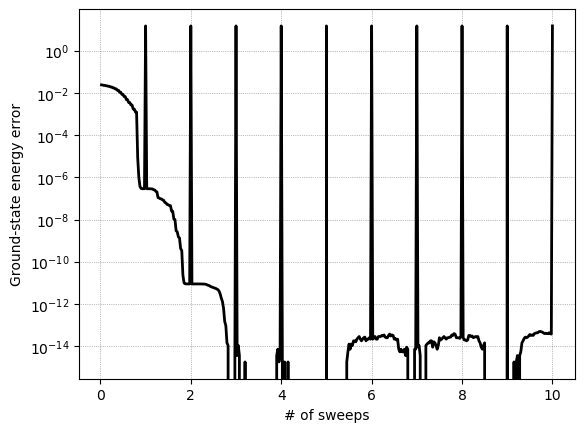

In [15]:
# Plot the error
x = (1:1:length(Eiter_GS))/N
Error = Eiter_GS.-E0_exact;
Error = reshape(Error,(length(Error)))

ylabel("Ground-state energy error");
xlabel("# of sweeps");
grid(linewidth=0.5,color="black",linestyle="dotted",alpha=0.5);
semilogy(x,Error,linewidth=2.0,color="black");

We see that the two-site DMRG converges faster in terms of iteration numbers, also in this case.

Moreover, we can see the bond-dimension of the GS:

In [16]:
size(M_GS[1])

(1, 2, 2)

In [17]:
size(M_GS[2])

(2, 2, 1)

In [18]:
size(M_GS[3])

(1, 2, 2)

In [20]:
size(M_GS[4])

(2, 2, 1)

We see that the bond dimension is oscillating between 1 and 2. It is another strength of the two-site DMRG; it automatically truncates unnecessary bond space.

Compute now the spin-spin correlation:

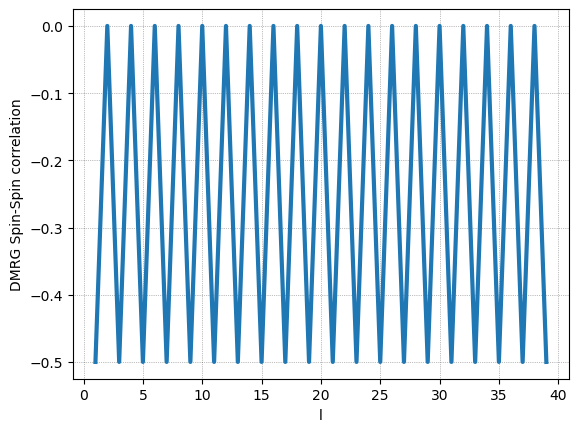

In [21]:
# G.S. SS-correlation
SS = zeros(N-1);

for itN in 2:N
    T = updateLeft([],[],M_GS[itN-1],reshape(S[:,1,:],(2,1,2)),3,M_GS[itN-1]);
    T = updateLeft(T,3,M_GS[itN],reshape(S[:,2,:],(2,1,2)),3,M_GS[itN]);
    for itN2 in (itN+1):N
        T = updateLeft(T,2,M_GS[itN2],[],[],M_GS[itN2]);
    end
    SS[itN-1] = T[1];
end
SS = SS.*(2); # the factor 2 is due to the presence of 1/sqrt(2) in both S[:,1,:] and S[:,2,:]

x = (1:(N-1));
ylabel("DMRG Spin-Spin correlation");
xlabel("l")
grid(linewidth=0.5,color="black",linestyle="dotted",alpha=0.5);
plot(x,SS,linewidth=3.0,label="G.S.");